## Imports

In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner
import glob
import re

import astropy
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
from scipy.stats import gaussian_kde
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
import gwpopulation as gwpop
from gwpopulation.models import mass, spin, redshift

from bilby.core.utils import logger
from gwpopulation import vt
from gwpopulation.cupy_utils import xp, to_numpy, trapz
from bilby.hyper.model import Model

from priors import *

xp = gwpop.cupy_utils.xp

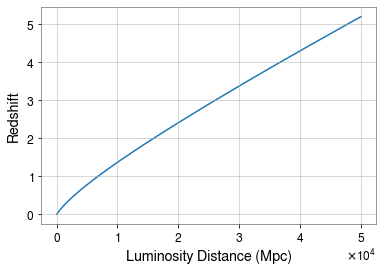

In [2]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1 * cost1 + a2 * q * cost2)/(1.0 + q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    term1 = a1 * np.sin(np.arccos(cost1))
    term2 = ((4.0*q + 3.0)/(4.0 + 3.0*q)) * q * a2 * np.sin(np.arccos(cost2))
    return np.max([term1, term2], axis = 0)

luminosity_distances = np.linspace(1, 50000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])

plt.plot(luminosity_distances, redshifts)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Redshift")
plt.show()

In [3]:
List = []

## Selection Effects

In [4]:
from gwpopulation.models.redshift import _Redshift, total_four_volume

class _BaseVT(object):
    def __init__(self, model, data):
        self.data = data
        if isinstance(model, list):
            model = Model(model)
            print("1")
        elif not isinstance(model, Model):
            model = Model([model])
            print("2")
        self.model = model

    def __call__(self, *args, **kwargs):
        raise NotImplementedError


class GridVT(_BaseVT):
    """
    Evaluate the sensitive volume on a grid.
    Parameters
    ----------
    model: callable
        Population model
    data: dict
        The sensitivity labelled `vt` and an entry for each parameter to be marginalized over.
    """

    def __init__(self, model, data):
        self.vts = data.pop("vt")
        super(GridVT, self).__init__(model=model, data=data)
        self.values = {key: xp.unique(self.data[key]) for key in self.data}
        shape = np.array(list(self.data.values())[0].shape)
        lens = {key: len(self.values[key]) for key in self.data}
        self.axes = {int(np.where(shape == lens[key])[0]): key for key in self.data}
        self.ndim = len(self.axes)

    def __call__(self, parameters):
        self.model.parameters.update(parameters)
        vt_fac = self.model.prob(self.data) * self.vts
        for ii in range(self.ndim):
            vt_fac = trapz(vt_fac, self.values[self.axes[self.ndim - ii - 1]], axis=-1)
        return vt_fac


class ResamplingVT(_BaseVT):
    """
    Evaluate the sensitive volume using a set of found injections.
    See https://arxiv.org/abs/1904.10879 for details of the formalism.
    Parameters
    ----------
    model: callable
        Population model
    data: dict
        The found injections and relevant meta data
    n_events: int
        The number of events observed
    """

    def __init__(self, model, data, n_events=np.inf):
        super(ResamplingVT, self).__init__(model=model, data=data)
        self.n_events = n_events
        self.total_injections = data.get("total_generated", len(data["prior"]))
        self.analysis_time = data.get("analysis_time", 1)
        self.redshift_model = None
        for _model in self.model.models:
            if isinstance(_model, _Redshift):
                self.redshift_model = _model
        if self.redshift_model is None:
            self._surveyed_hypervolume = total_four_volume(
                lamb=0, analysis_time=self.analysis_time
            )

    def __call__(self, parameters):
        """
        Compute the expected number of detections given a set of injections.
        This should be implemented as in https://arxiv.org/abs/1904.10879
        If n_effective < 4 * n_events we return np.inf so that the sample
        is rejected.
        Parameters
        ----------
        parameters: dict
            The population parameters
        """
        mu, var = self.detection_efficiency(parameters)
        new_row = [mu, var, parameters["alpha"], parameters["beta"], parameters["mmin"], parameters["mmax"],
                   parameters["mu_chi_eff"], parameters["sigma_chi_eff"], 
                   parameters["mu_chi_p"], parameters["sigma_chi_p"], parameters["spin_covariance"]]
        List.append(new_row)
        
        if mu ** 2 <= 4 * self.n_events * var:
            return np.inf
        n_effective = mu ** 2 / var
        vt_factor = mu / np.exp((3 + self.n_events) / 2 / n_effective)
        return vt_factor

    def detection_efficiency(self, parameters):
        self.model.parameters.update(parameters)
        weights = self.model.prob(self.data) / self.data["prior"]
        mu = float(xp.sum(weights) / self.total_injections)
        var = float(
            xp.sum(weights ** 2) / self.total_injections ** 2
            - mu ** 2 / self.total_injections
        )
        return mu, var

    def surveyed_hypervolume(self, parameters):
        r"""
        The total surveyed 4-volume with units of :math:`Gpc^3yr`.
        .. math::
            \mathcal{V} = \int dz \frac{dV_c}{dz} \frac{\psi(z)}{1 + z}
        If no redshift model is specified, assume :math:`\psi(z)=1`.
        Parameters
        ----------
        parameters: dict
            Dictionary of parameters to compute the volume at
        Returns
        -------
        float: The volume
        """
        if self.redshift_model is None:
            return self._surveyed_hypervolume
        else:
            return (
                self.redshift_model.normalisation(parameters) / 1e9 * self.analysis_time
            )

In [5]:
def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    q = np.array(m2/m1)
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    chi_eff = np.array((1.*s1z + q*s2z)/(1. + q))
    chi_p = np.array(np.max([s1z, ((3+4*q)/(4+3*q))*q*s2z], axis = 0))
    
    pmass = np.array(m1**(-2.35+1) * q**2)
    pchieff = np.zeros(chi_eff.size)
    
    for i in range(chi_eff.size):
        pchieff[i] = chi_effective_prior_from_aligned_spins(q[i], 1, chi_eff[i])

    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(q[found]),
        redshift = xp.asarray(z[found]),
        chi_eff = xp.asarray(chi_eff[found]),
        chi_p = xp.asarray(chi_p[found]),
        pchieff = xp.asarray(pchieff[found]),
        pmass = xp.asarray(pmass[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt_spin(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"]

    return ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["pchieff"] * data["pmass"]

    return ResamplingVT(model = model, data = data, n_events = 44)

def injection_resampling_vt_spin_mass_redshift(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["prior"] * data["pchieff"]

    return ResamplingVT(model = model, data = data, n_events = 44)

In [6]:
def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([spin.gaussian_chi_eff, 
                      mass.power_law_primary_mass_ratio])
    vt_func = injection_resampling_vt_spin_mass
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

19:13 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


## Test

In [7]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [8]:
par = priors.sample(100000)
par = pd.DataFrame.from_dict(par)
par

,alpha,beta,mmin,mmax,mu_chi_eff,sigma_chi_eff,mu_chi_p,sigma_chi_p,spin_covariance
0,-2.2,1.3,5.0,75.0,-0.459416,0.767869,0.344753,0.220449,0.347420
1,-2.2,1.3,5.0,75.0,0.156545,0.088784,0.435082,0.426233,-0.083155
2,-2.2,1.3,5.0,75.0,-0.396184,0.821520,0.541025,0.539434,0.310638
3,-2.2,1.3,5.0,75.0,0.306710,0.538850,0.957722,0.356389,-0.415052
4,-2.2,1.3,5.0,75.0,-0.746081,0.705397,0.221681,0.967842,-0.149710
...,...,...,...,...,...,...,...,...,...
99995,-2.2,1.3,5.0,75.0,0.761596,0.462865,0.195127,0.155070,0.670369
99996,-2.2,1.3,5.0,75.0,-0.128533,0.809632,0.142405,0.524355,0.319716
99997,-2.2,1.3,5.0,75.0,-0.347720,0.118730,0.841333,0.695339,0.146975
99998,-2.2,1.3,5.0,75.0,-0.751039,0.440755,0.434853,0.020245,0.726826


In [9]:
# for i in range(len(par)):
#     print(par.loc[i,:])
#     break;

In [10]:
# par = priors.sample(1000)
# for i in par.items():
#     print(i[1][0])

In [11]:
for i in range(len(par)):
    ans = selection_function(par.loc[i,:])

In [12]:
# print(List)

### Posteriors

In [8]:
## Only run this to load posteriors if they have already been calculated

posteriors = list()

i = 0
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
#     print(i, filename)
    i = i+1
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)
    
# Sampling pdfs

for posterior in posteriors:
    
    # Joint prior for chi_eff and chi_p is posterior["joint_prior"]
    
    # Mass prior 
    PRIOR_VOLUME = (100. - 2.) ** 2
    posterior["mass_prior"] = (posterior["mass_1"] * (1+posterior["redshift"])**2)/PRIOR_VOLUME
    
    # Redshift prior
#     posterior["redshift_prior"] = redshift_prior(posterior['redshift'])

In [9]:
model = bilby.hyper.model.Model([spin.GaussianChiEffChiP(),
                                 mass.power_law_primary_mass_ratio])

for posterior in posteriors:
    posterior["prior"] = posterior["joint_prior"] * posterior["mass_prior"]

In [10]:
priors = PriorDict()

# mass
priors["alpha"] = -2.2
priors["beta"] = 1.3
priors["mmin"] = 5
priors["mmax"] = 75

# spin
priors["mu_chi_eff"] = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$')
priors["sigma_chi_eff"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$')
priors["mu_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_\mathrm{p}$')
priors["sigma_chi_p"] = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{p}$')
priors["spin_covariance"] = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')

In [11]:
likelihood = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                    hyper_prior = model,
                                                    selection_function = selection_function)

In [12]:
likelihood.parameters.update(priors.sample())

In [13]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty',
                           nlive = 1000, label = "injection_test", 
                           outdir = "injection_test", clean = True)

12:17 bilby INFO    : Running for label 'injection_test', output will be saved to 'injection_test'
12:17 bilby INFO    : Search parameters:
12:17 bilby INFO    :   alpha = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
12:17 bilby INFO    :   beta = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta_\\mathrm{q}$', unit=None, boundary=None)
12:17 bilby INFO    :   mmin = Uniform(minimum=2, maximum=10, name=None, latex_label='$m_\\mathrm{min}$ $[M_\\odot]$', unit=None, boundary=None)
12:17 bilby INFO    :   mmax = Uniform(minimum=30, maximum=100, name=None, latex_label='$m_\\mathrm{max}$ $[M_\\odot]$', unit=None, boundary=None)
12:17 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
12:17 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
12:17 bilby INFO

0it [00:00, ?it/s]

12:17 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7febd8e707c0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:17 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:17 bilby INFO    : Using dynesty version 1.0.1
12:17 bilby INFO    : Using the bilby-implemented rwalk sam

18:21 bilby INFO    : Sampling time: 6:02:18.392842
18:21 bilby INFO    : Summary of results:
nsamples: 21375
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.161
ln_bayes_factor: 331.818 +/-  0.161



In [13]:
a = np.array(List)

In [14]:
result_df = pd.DataFrame()

result_df["mu"] = a[:,0]
result_df["var"] = a[:,1]
result_df["alpha"] = a[:,2]
result_df["beta"] = a[:,3]
result_df["mmin"] = a[:,4]
result_df["mmax"] = a[:,5]
result_df["mu_chi_eff"] = a[:,6]
result_df["sigma_chi_eff"] = a[:,7]
result_df["mu_chi_p"] = a[:,8]
result_df["sigma_chi_p"] = a[:,9]
result_df["spin_covariance"] = a[:,10]
result_df["acceptance"] = False 

for ii in range(len(result_df)):
    if result_df["mu"][ii]**2 >= 4 * 44 * result_df["var"][ii]:
        result_df["acceptance"][ii] = True
    else:
        result_df["acceptance"][ii] = False
        
result_df.to_csv("inj_spin_mass.csv", index=False)

<ipython-input-14-c926482898ab>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["acceptance"][ii] = True
<ipython-input-14-c926482898ab>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["acceptance"][ii] = False


In [15]:
j = 0
for i in range(len(result_df)):
    if result_df["acceptance"][i] == False:
        j=j+1
print(j, len(result_df))

2311 100000


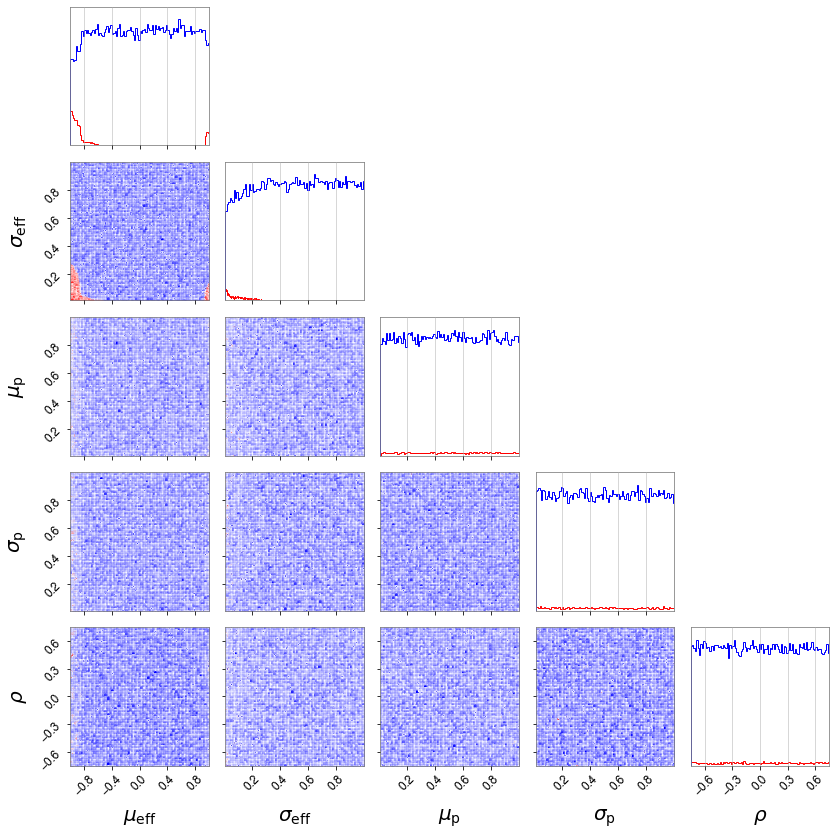

In [16]:
params = ["mu_chi_eff", "sigma_chi_eff", "mu_chi_p", "sigma_chi_p", "spin_covariance"]
labels = ["$\\mu_{\mathrm{eff}}$", "$\\sigma_{\mathrm{eff}}$", 
          "$\\mu_{\mathrm{p}}$", "$\\sigma_{\mathrm{p}}$", "$\\rho$"]

data1 = result_df.loc[(result_df["acceptance"] == False), params].values
data2 = result_df.loc[(result_df["acceptance"] == True), params].values

fig = corner.corner(data1, color="red",bins = 100, label_kwargs=dict(fontsize=20), plot_contours =False,
                    plot_datapoints=True, labels=labels)
corner.corner(data2, color="blue", bins = 100, label_kwargs=dict(fontsize=20),plot_contours = False,
              plot_datapoints=True, labels=labels, fig=fig)

plt.tight_layout()
plt.show()

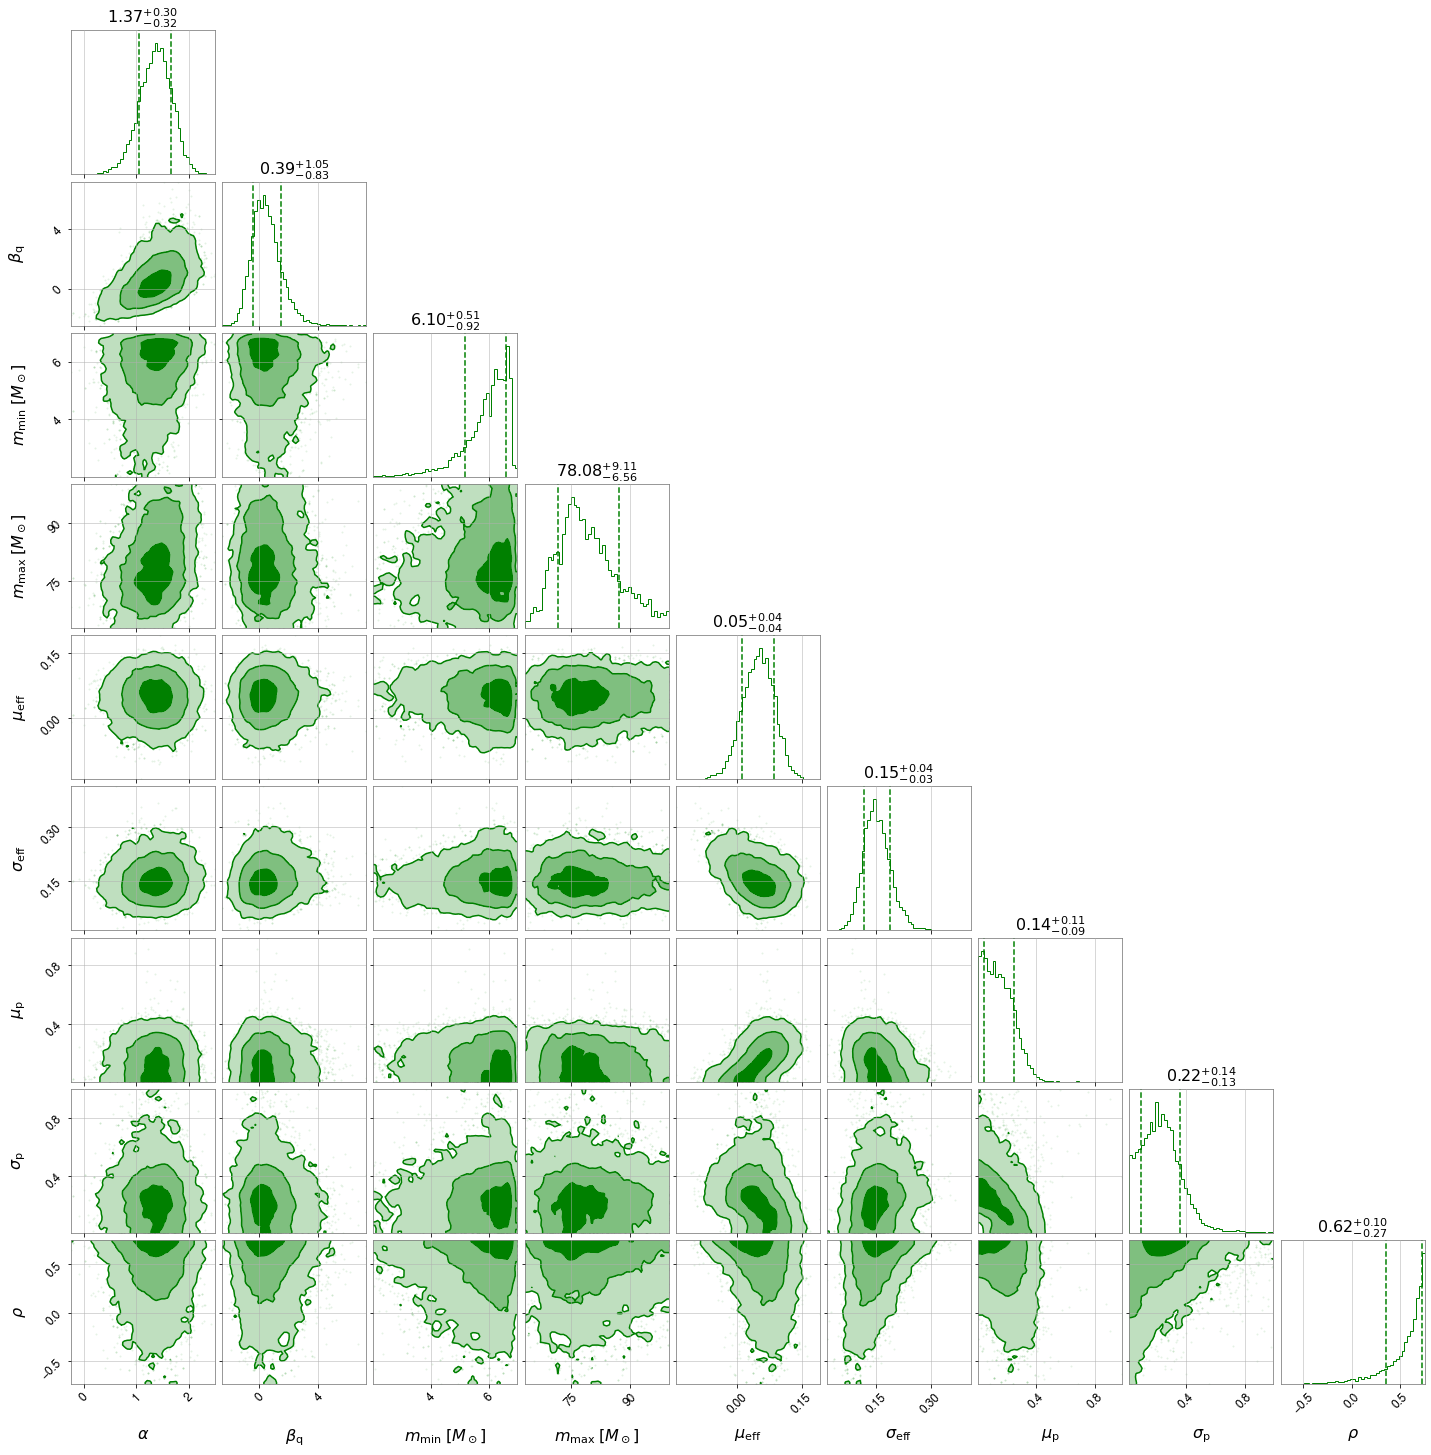

In [18]:
result.plot_corner(color="g")